In [2]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import math
import networkx as nx
from matplotlib.lines import Line2D   
from fast_pagerank import pagerank
from scipy import sparse   

from utils_inference import plot_loss_curves, get_accuracy_score
from autoencoder import full_network
from training import create_feed_dictionary
%matplotlib inline

In [3]:
chosen_dataset='Pancreas' #Choose from 'Bone Marrow','Pancreas','SERGIO'. Needs to be the directory name
root_dataset_files_path=f'../{chosen_dataset}'
# Load the preprocessed time series
data_dict= pickle.load(open(os.path.join(root_dataset_files_path, 'time_series.pkl'),'rb'))

In [4]:
experiment_names=[]
experiment_dir_name='Test'
experiment_results=pickle.load(open(os.path.join(root_dataset_files_path,f'experiment_results_{experiment_dir_name}.pkl'),'rb'))


for name in os.listdir(os.path.join(root_dataset_files_path,experiment_dir_name)):
        name_list=name.split(".")
        if(len(name_list)>1 and name_list[1]=="index"):
            experiment_names.append(name_list[0])

### Select experiment indices you want to run an inference on. You can choose multiple experiments, plot their metrics and choose the best experimetns for creation of inference networks and running Biology


In [5]:
# Tracked using the time of the experimet
print(experiment_names)
chosen_idx=[0,1] #List of indices

['2024_09_19_01176849', '2024_09_19_01497735', '2024_09_19_01538782', '2024_09_19_01637947', '2024_09_19_01690453', '2024_09_19_01768966', '2024_09_19_01853133']


2024_09_19_01176849


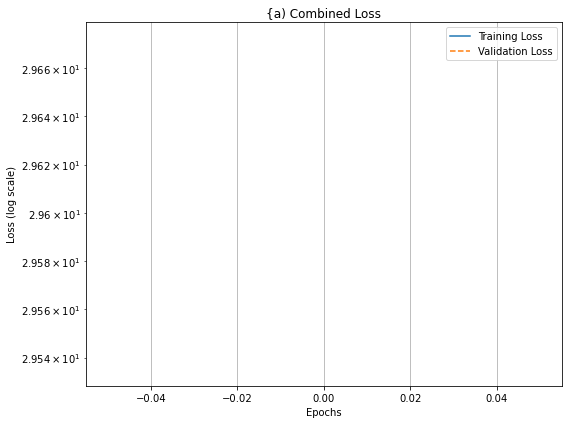

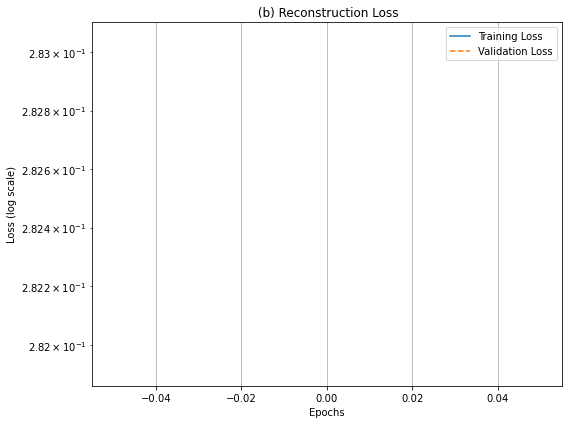

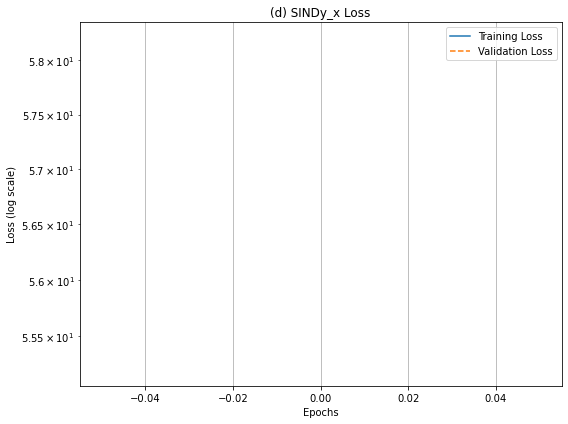

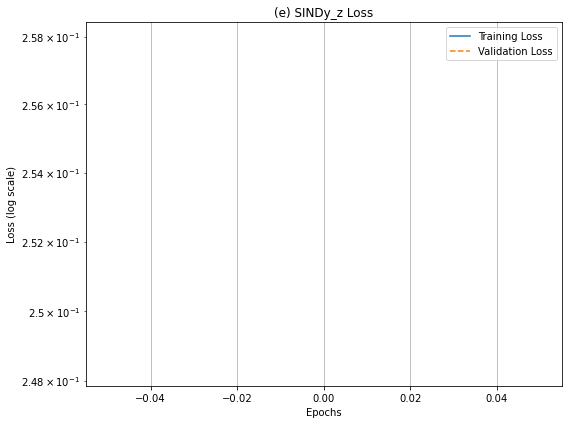

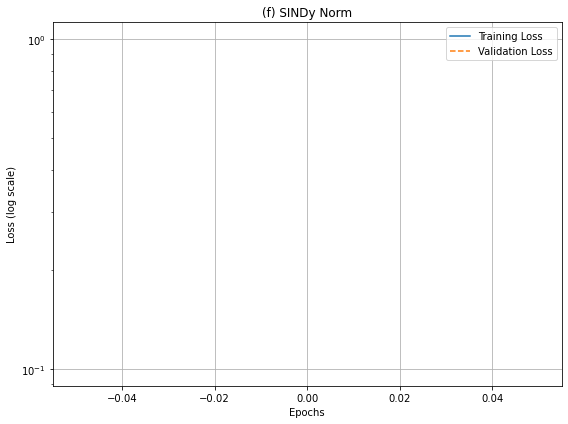

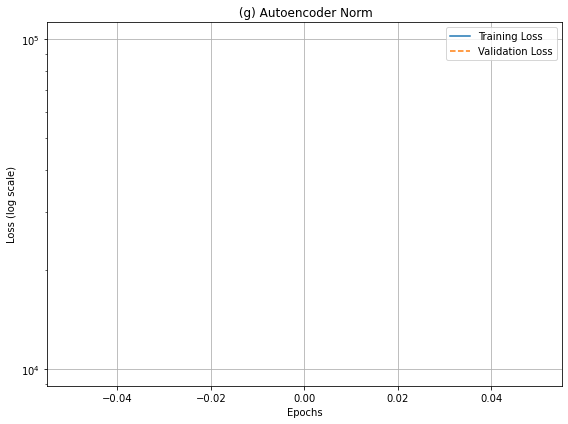

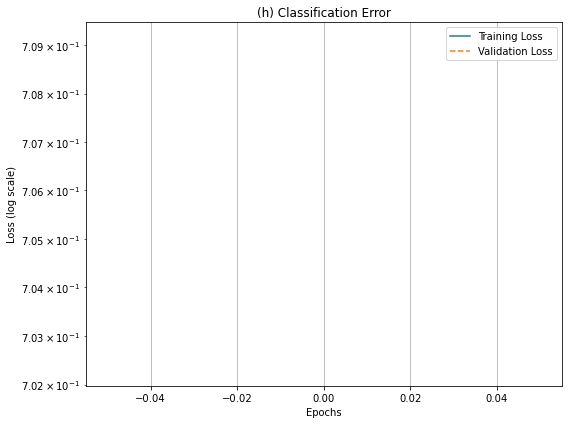

2024_09_19_01497735


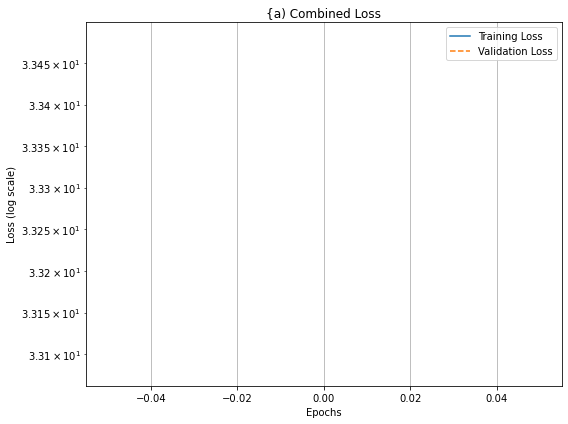

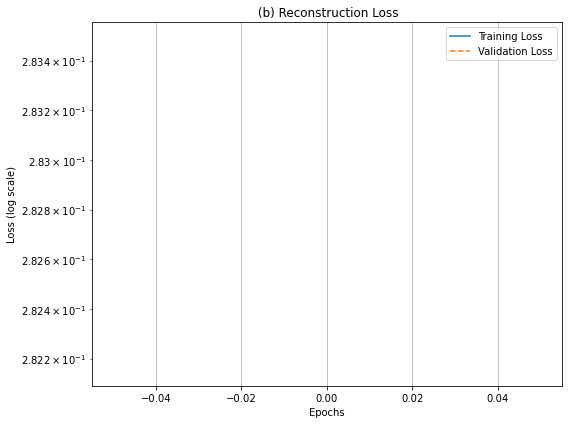

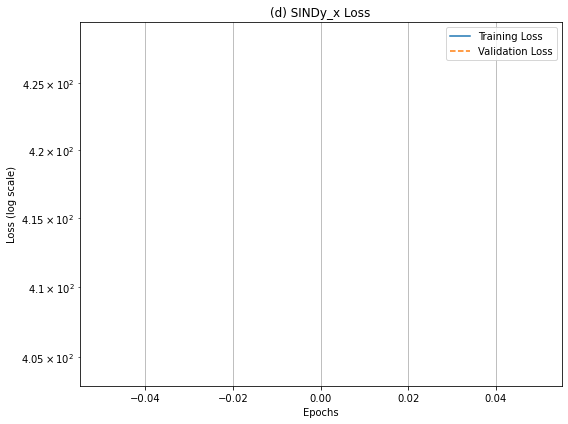

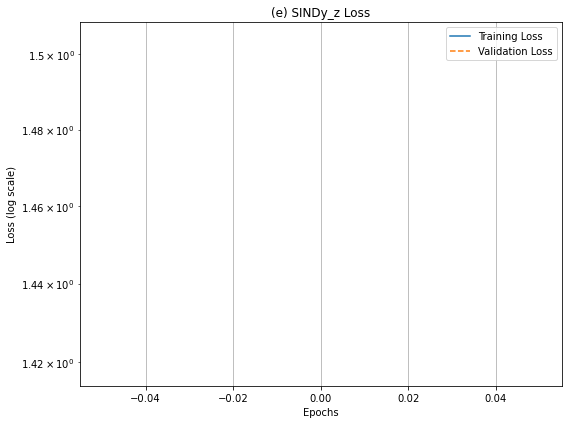

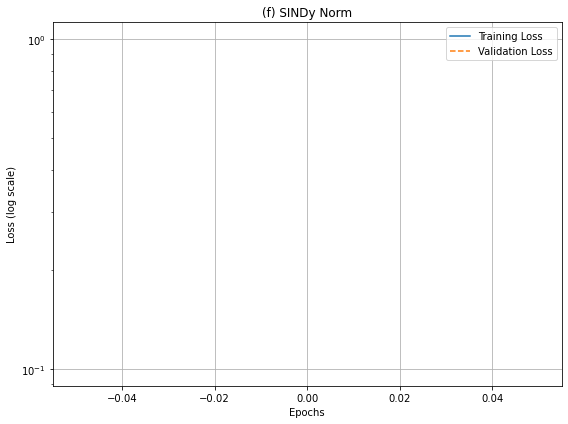

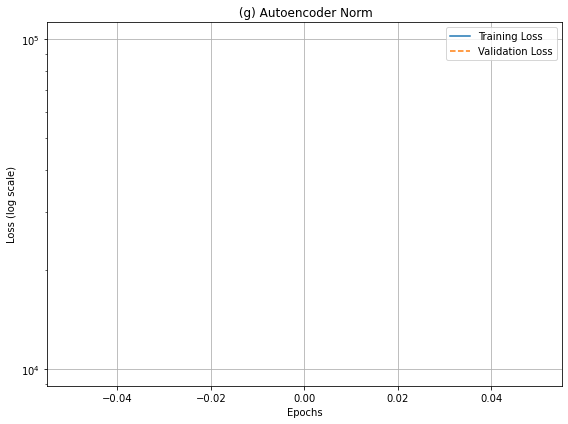

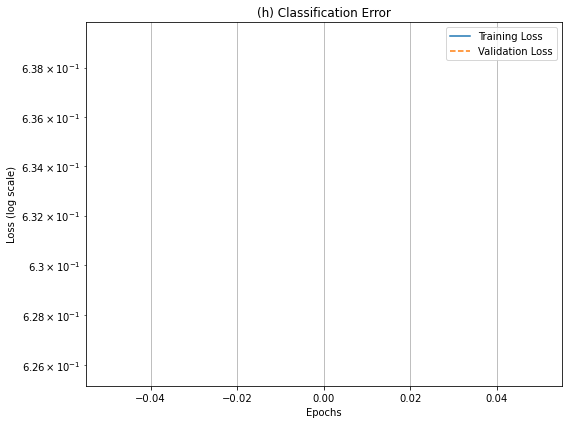

In [6]:
for idx in chosen_idx:
    print(experiment_names[idx])
    train_loss, val_loss=experiment_results.iloc[idx, -6:-4]
    plot_loss_curves(train_loss, val_loss)

In [7]:
class Errors:
    def __init__(self):
        self.decoder_x_error = None  # Initialize with an appropriate default value
        self.decoder_dx_error = None  # Initialize with an appropriate default value
        self.sindy_dz_error = None  # Initialize with an appropriate default value

    def calculate_relative_errors(self, test_data, model):
        self.decoder_x_error = np.mean((test_data['x'] - model['x_decode'])**2) / np.mean(test_data['x']**2)
        self.decoder_dx_error = np.mean((test_data['dx'] - model['dx_decode'])**2) / np.mean(test_data['dx']**2)
        self.sindy_dz_error = np.mean((model['dz'] - model['dz_predict'])**2) / np.mean(model['dz']**2)

    def print_errors(self):
        print('Decoder relative error: %f' % self.decoder_x_error)
        print('Decoder relative SINDy error: %f' % self.decoder_dx_error)
        print('SINDy relative error, z: %f' % self.sindy_dz_error)
        
class Experiment:
    def __init__(self):
        self.params = None
        self.save_name=None
        self.model={}
        self.idx=0
        self.errors=None

    def find_errors(self, test_data):
        self.errors=Errors()
        self.errors.calculate_relative_errors(test_data, self.model, )
        self.errors.print_errors()

class Experiments():
    def __init__ (self):
        self.experiments={}
    def add_experiment(self, num, exp):
        self.experiments[num] = exp
    def add_errors(self, num, test_data):
        self.experiments[num].find_errors(test_data)

In [8]:
### Relative errors

In [17]:
experiments=Experiments()
for exp_number, save_name in enumerate(experiment_names):
  if exp_number in chosen_idx:
    experiment=Experiment()
    print(exp_number)
    #add the folder name where the result is present
    #add the model save name
    experiment.params_path= os.path.join(root_dataset_files_path,experiment_dir_name,save_name+'_params.pkl')
    experiment.params = pickle.load(open(experiment.params_path, 'rb'))

    tf.reset_default_graph()
    autoencoder_network = full_network(experiment.params)
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
    # temp_models={}fmodel
    
    tensorflow_run_tuple = ()
    new_keys={}
    # temp_models={}
    for key in autoencoder_network.keys():
            new_keys[key]=0
            tensorflow_run_tuple += (autoencoder_network[key],)
    with tf.Session() as sess:
        # Initialize global variables and restore the saved model
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, os.path.join(root_dataset_files_path,experiment_dir_name,experiment.params['save_name']))
        # Create a feed dictionary for the test data
        test_dictionary = create_feed_dictionary(data_dict, experiment.params)
        # Execute the TensorFlow operations on the test data
        tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

    for i, key in enumerate(autoencoder_network.keys()):
        # if key not in [ 'class_labels', 'class_score', 'classifier_weights', 'classifier_biases']:
           experiment.model[key]=tf_results[i]
    experiment.idx=exp_number
    experiments.add_experiment(exp_number, experiment)
    experiments.add_errors(exp_number, data_dict)

0
INFO:tensorflow:Restoring parameters from ../Pancreas\Test\2024_09_19_01176849
Decoder relative error: 0.854650
Decoder relative SINDy error: 4113.033357
SINDy relative error, z: 1571719.125000
1
INFO:tensorflow:Restoring parameters from ../Pancreas\Test\2024_09_19_01497735
Decoder relative error: 0.872489
Decoder relative SINDy error: 1634.339707
SINDy relative error, z: 393494.656250


In [10]:
idx_to_ctype=pickle.load(open(os.path.join(root_dataset_files_path, 'class_idx_to_cell_type_dict.pkl'),'rb'))
num_cell_types=len(idx_to_ctype)

In [11]:
idx_to_time_indices=[]
for i in range(num_cell_types):
    idx_to_time_indices.append(list(np.where(np.argmax(experiment.model['class_labels'],axis=1)==i)[0]))

### Plot the classification matrix for the chosen experiment

In [14]:
for exp_num in chosen_idx:
    experiments.experiments[exp_num].idx_to_ctype=idx_to_ctype
    experiments.experiments[exp_num].idx_to_time_indices=idx_to_time_indices
    get_accuracy_score(experiments.experiments[exp_num],idx_to_ctype)

Confusion Matrix:
[[  0   0   0   0   0   0 109]
 [  0   0   0   0   0   0 147]
 [  0   0   0   0   0   0 462]
 [  0   0   0   0   0   0  19]
 [  0   0   0   0   0   0 323]
 [  0   0   0   0   0   0 122]
 [  0   0   0   0   0   0 253]]

Classification Report:
               precision    recall  f1-score   support

        Alpha       0.00      0.00      0.00       109
         Beta       0.00      0.00      0.00       147
       Ductal       0.00      0.00      0.00       462
      Epsilon       0.00      0.00      0.00        19
 Ngn3 high EP       0.00      0.00      0.00       323
  Ngn3 low EP       0.00      0.00      0.00       122
Pre-endocrine       0.18      1.00      0.30       253

     accuracy                           0.18      1435
    macro avg       0.03      0.14      0.04      1435
 weighted avg       0.03      0.18      0.05      1435

Accuracy: 0.17630662020905924
Confusion Matrix:
[[109   0   0   0   0   0   0]
 [147   0   0   0   0   0   0]
 [462   0   0   0   0 

c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vasu\anaconda3\e

In [ ]:
for exp_num in chosen_idx:
    common=(experiments.experiments[exp_num].model['coefficient_mask']*experiments.experiments[exp_num].model['sindy_coefficients']).T
    equations, active_terms= build_equations(common,
                                resulting_library, 0, terms)
    
    
    nature_all=[nature]*params['latent_dim']
    signum_array=np.sign(common)*nature_all
    print(active_terms)
    # draw_graph(active_terms,signum_array)
    for i, equation in enumerate(equations):
        print(f"Equation {i}: {equation}")